In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from PIL import Image

from IPython import display
import time

import copy

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

## Soft kNN layer

In [17]:
class SoftKNN(nn.Module):
    def __init__(self, Nfeat1, Nfeat2, Ndim, Nval, alpha= 1):
        super(SoftKNN, self).__init__()
        self.tokey = nn.Conv1d(Nfeat1,Ndim,1)
        self.toval = nn.Conv1d(Nfeat2,Nval,1)
        self.alpha = alpha
    
    def attention(self, mem, x):
        xmem = self.tokey(mem)
        xc = self.tokey(x)
        
        # w = BATCH x 1 x LOOKUP x MEMORY
        w = torch.clamp(self.alpha * torch.sqrt(torch.sum( (xc.unsqueeze(3)-xmem.unsqueeze(2))**2, 1, keepdim=True ) + 1e-8), 0, 30)
        w = torch.exp(-w)
        
        w = w/(torch.sum(w,3,keepdim=True) + 1e-8)
        
        return w
        
    def forward(self, memx, memy, x):        
        w = self.attention(memx, x)
        zmem = self.toval(memy)
        
        # v = BATCH x VAL x LOOKUP
        v = torch.sum(w*zmem.unsqueeze(2),3)        
        
        return v


## Neural network definition

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        # Embedding layers for state/action pairs, and for the query
        self.emb1 = nn.Conv1d(2+2, 256, 1)
        self.emb2 = nn.Conv1d(256, 256, 1)
        self.emb3 = nn.Conv1d(256, 256, 1)
        self.emb4 = nn.Conv1d(256, 256, 1)
        
        # Embedding layers for state/action/outcome triples
        self.emby1 = nn.Conv1d(2+2+1, 256, 1)
        self.emby2 = nn.Conv1d(256, 256, 1)
        self.emby3 = nn.Conv1d(256, 256, 1)
        self.emby4 = nn.Conv1d(256, 256, 1)
        
        # Attentional layer
        self.dknn1 = SoftKNN(256, 256, 24, 128, alpha = 20.0)

        self.pred1 = nn.Conv1d(128, 256, 1)
        self.pred2 = nn.Conv1d(256, 256, 1)
        self.pred3 = nn.Conv1d(256, 256, 1)
        self.pred4 = nn.Conv1d(256, 256, 1)
        self.pred5 = nn.Conv1d(256, 1, 1)        

        self.optimizer = torch.optim.Adam(self.parameters(), lr=4e-4)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.9, patience=10, verbose=True)

    def embed_x(self, memx):        
        z = F.relu(self.emb1(memx))
        z = F.relu(self.emb2(z))
        z = F.relu(self.emb3(z))
        z = F.relu(self.emb4(z))

        return z
    
    def embed_y(self, memx, memy):
        z = F.relu(self.emby1(torch.cat([memx,memy],1)))
        z = F.relu(self.emby2(z))
        z = F.relu(self.emby3(z))        
        z = F.relu(self.emby4(z))        

        return z

    def predict(self, mmx, mmy, ttx):
        z = self.dknn1(mmx,mmy,ttx)
        
        z = F.relu(self.pred1(z))
        z = F.relu(self.pred2(z))
        z = F.relu(self.pred3(z))        
        z = F.relu(self.pred4(z))
        z = self.pred5(z)

        return torch.clamp(F.sigmoid(z),1e-6,1-1e-6)

    def forward(self, mx, my, tx):
        mmx = self.embed_x(mx)
        mmy = self.embed_y(mx, my)
        ttx = self.embed_x(tx)

        z = self.predict(mmx,mmy,ttx)

        return z
    
    # Determine the relative novelties of a set of proposals 'tx'
    # Expects batch size of 1
    def novelty(self, mx, tx):
        mmx = self.embed_x(mx)
        ttx = self.embed_x(tx)
        
        w = self.dknn1.attention(mmx,ttx)[:,0,:,:]
        
        mpos = self.dknn1.tokey(mmx)
        tpos = self.dknn1.tokey(ttx)
        
        pv, pi = torch.max(w,2)
        
        d = torch.sum( (mpos[:,:,pi[0,:]] - tpos)**2, 1)
        
        return d
    
    # Determine the informativeness of a set of proposals 'tx' towards 'query'
    # Expects batch size of 1
    def informativeness(self, mx, tx, query):
        mmx = self.embed_x(mx)        
        ctx = self.embed_x(tx)        
        qx = self.embed_x(query)
        
        w = self.dknn1.attention(torch.cat([mmx,ctx],2),qx)[:,0,:,:]
        w = w[0,:,mmx.size()[2]:]
        
        return w
    
    def set_learning(self, lr):
        for param_group in self.adam.param_groups:
            param_group['lr'] = lr


## Task definition

In [4]:
DT = 0.005

class Roomba():
    def __init__(self, floorplan):
        self.floorplan = floorplan
        self.randomize()
    
    def randomize(self):
        stop = False
        while not stop:
            self.x = np.random.rand()
            self.y = np.random.rand()
            
            x = int(256*self.x)
            y = int(256*self.y)
            if not self.floorplan[x,y]:
                stop = True
        
    def sensor(self):
        return np.array([self.x, self.y])
    
    def act(self, dx, dy):
        s = 0.15
        collide = 0
        
        for i in range(50):            
            nx = self.x + DT*s*dx
            ny = self.y + DT*s*dy
            
            x = int(256*nx)
            y = int(256*ny)
            
            if self.floorplan[x,y]:
                nx = self.x
                ny = self.y
                
                if self.floorplan[x-1,y] or self.floorplan[x+1,y]:
                    dy *= -1
                if self.floorplan[x,y-1] or self.floorplan[x,y+1]:
                    dx *= -1
                
                collide = 1
            
            self.x = nx
            self.y = ny
        
        return collide
    
def generateFloor():
    floorplan = np.ones((256,256))
    
    i = 0
    while i<1:
        x1 = 16 + np.random.randint(256-32)
        y1 = 16 + np.random.randint(256-32)
        x2 = 16 + np.random.randint(256-32)
        y2 = 16 + np.random.randint(256-32)
        lx = np.minimum(x1,x2)
        ux = np.maximum(x1,x2)
        ly = np.minimum(y1,y2)
        uy = np.maximum(y1,y2)
    
        if abs(x1-x2)>8 and abs(y1-y2)>8:
            floorplan[lx:ux,ly:uy] = 0
            i += 1
    
    i = 0
    while i<16:
        x1 = 16 + np.random.randint(256-32)
        y1 = 16 + np.random.randint(256-32)
        x2 = 16 + np.random.randint(256-32)
        y2 = 16 + np.random.randint(256-32)
        
        lx = np.minimum(x1,x2)
        ux = np.maximum(x1,x2)
        ly = np.minimum(y1,y2)
        uy = np.maximum(y1,y2)
        
        if abs(x1-x2)>8 and abs(y1-y2)>8 and np.sum(1-floorplan[lx:ux,ly:uy])>0 and (ux-lx)*(uy-ly)<64*64:
            floorplan[lx:ux,ly:uy] = 0    
            i += 1
    
    return floorplan

## Dataset containers

Classes for assembling the training and test data, and drawing random batches.

In [5]:
class Data():
    def __init__(self):
        self.starts = np.zeros((0,2))
        self.ends = np.zeros((0,1))
        self.acts = np.zeros((0,2))
        
    def add(self, start, end, act):
        self.starts = np.vstack([self.starts, start.reshape((1,2))])
        self.ends = np.vstack([self.ends, end.reshape((1,1))])
        self.acts = np.vstack([self.acts, act.reshape((1,2))])

class DataSet():
    def __init__(self):
        self.data = []
        
    def getBatch(self, BS=100, MS=100, TS=100):
        memx = []
        memy = []
        testx = []
        testy = []
        
        for i in range(BS):
            j = np.random.randint(len(self.data))
            idx = np.random.randint(self.data[j].starts.shape[0]-MS-TS)
            
            memx.append( np.hstack( [ self.data[j].starts[idx:idx+MS], self.data[j].acts[idx:idx+MS] ]) )
            memy.append(self.data[j].ends[idx:idx+MS])
            testx.append( np.hstack( [ self.data[j].starts[idx+MS:idx+MS+TS], self.data[j].acts[idx+MS:idx+MS+TS]]) )
            testy.append(self.data[j].ends[idx+MS:idx+MS+TS])
        
        return np.array(memx).transpose(0,2,1), \
               np.array(memy).transpose(0,2,1), \
               np.array(testx).transpose(0,2,1), \
               np.array(testy).transpose(0,2,1)
    
    def generate(self):
        data = Data()
        floorplan = generateFloor()
        agent = Roomba(floorplan)
        agent.randomize()
        
        for i in range(1000):
            theta = np.random.rand()*2*pi
            act = np.array([cos(theta), sin(theta)])
            start = agent.sensor()
            end = np.array([agent.act(act[0], act[1])])
            
            acts = act.reshape((1,2))
            data.add(start, end, acts)
        
        self.data.append(data)

## Generate training data

In [ ]:
import tqdm

dataset = DataSet()

for i in tqdm.tqdm_notebook(range(1000)):
    dataset.generate()

## Generate test data

In [ ]:
testset = DataSet()

for i in tqdm.tqdm_notebook(range(500)):
    testset.generate()
    print(i)

## Instantiate neural network (and load from save state)

In [41]:
net = Net().cuda()
net.load_state_dict(torch.load("models/curious_roomba_ref_150.th"))

## Train network

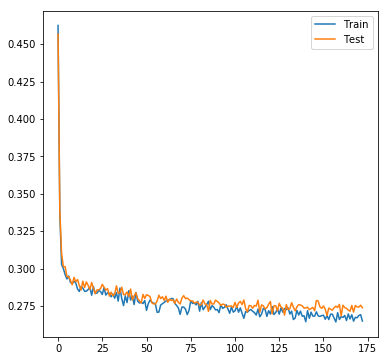

KeyboardInterrupt: 

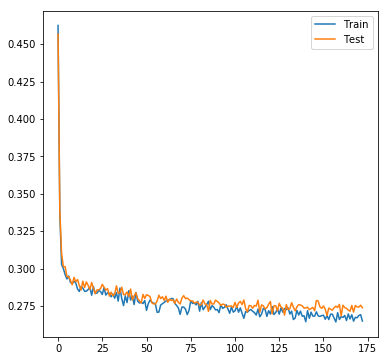

In [29]:
tr_errs = []
ts_errs = []

for step in range(150):
    err = 0
    count = 0
    
    testerr = 0

    if step%25 == 0:
        torch.save(net.state_dict(), open("models/curious_roomba_ref_%d.th" % step,"wb"))
    
    for i in range(100):
        mx,my,tx,ty = testset.getBatch(BS=50, MS=300)

        y = tovar(ty)
        p = net.forward(tovar(mx), tovar(my), tovar(tx))
        loss = -torch.mean( y*torch.log(p) + (1-y)*torch.log(1-p) )
        tloss = loss.cpu().data.numpy()[0]
        testerr += loss.cpu().data.numpy()[0]/100.0
        
        mx,my,tx,ty = dataset.getBatch(BS=50, MS=300)

        net.zero_grad()
        y = tovar(ty)
        p = net.forward(tovar(mx), tovar(my), tovar(tx))
        loss = -torch.mean( y*torch.log(p) + (1-y)*torch.log(1-p) )
        loss.backward()
        
        net.optimizer.step()
        
        err += loss.cpu().data.numpy()[0]/100.0
    
    net.scheduler.step(testerr)
    ts_errs.append(testerr)
    tr_errs.append(err)
        
    plt.clf()
    
    plt.plot(tr_errs,label="Train")
    plt.plot(ts_errs,label="Test")
    plt.legend()
        
    plt.gcf().set_size_inches((6,6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

## Generate single run examples of novelty-search trajectories

In [42]:
# Novelty search based policy
def iterateCuriosity(N, PROPOSALS=50):
    for i in range(N):
        memx = []
        memy = []
        idx = 0

        memx.append( np.hstack( [ rmem.starts[idx:-10], rmem.acts[idx:-10] ]) )
        memy.append( rmem.ends[idx:-10])

        testx = []
        actlist = []
        for j in range(PROPOSALS):
            theta = np.random.rand()*2*pi
            start = np.array([agent.x, agent.y]).reshape(1,2)
            acts = np.zeros((1,2))
            acts[0,0] = cos(theta)
            acts[0,1] = sin(theta)
            actlist.append(acts[0])
            testx.append(np.hstack( [start, acts] ))

        testx = np.array(testx).transpose(1,2,0)
        memx = np.array(memx).transpose(0,2,1)
        memy = np.array(memy).transpose(0,2,1)

        n = net.novelty(tovar(memx), tovar(testx)).cpu().data.numpy()[0]
        n = n + np.random.randn(PROPOSALS,)*0.003
        act = actlist[np.argmax(n)]

        start = agent.sensor()
        end = np.array([agent.act(act[0],act[1])])

        acts = act.reshape((1,2))
        rmem.add(start, end, acts)

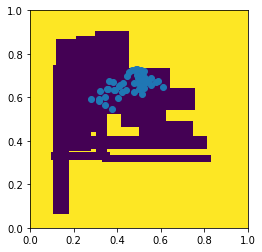

In [43]:
floorplan = generateFloor()
agent = Roomba(floorplan)
agent.randomize()

rmem = Data()

# Initial seed memory
for i in range(50):
    theta = np.random.rand()*pi*2
    acts = np.array([cos(theta), sin(theta)]).reshape((1,2))
    start = agent.sensor()
    end = np.array([agent.act(acts[0,0],acts[0,1])])

    rmem.add(start, end, acts)

plt.imshow(floorplan.T,extent=[0,1,1,0])
plt.scatter(rmem.starts[:,0], rmem.starts[:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [44]:
iterateCuriosity(250)

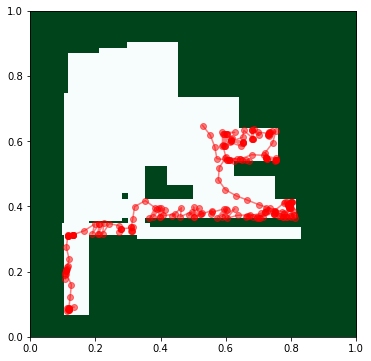

In [45]:
plt.imshow(floorplan.T,extent=[0,1,1,0], cmap=plt.cm.BuGn)
#plt.plot(rmem.starts[0:150,0], rmem.starts[0:150,1],'bo-',alpha=1)
plt.plot(rmem.starts[50:,0], rmem.starts[50:,1],'ro-', alpha=0.5)
plt.xlim(0,1)
plt.ylim(0,1)
plt.gcf().set_size_inches((6,6))
plt.show()

## Visualize novelty distribution

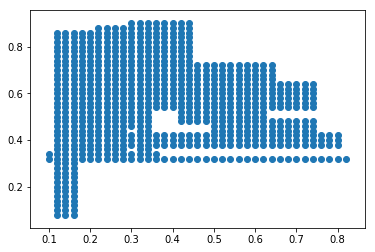

In [46]:
ptsx, ptsy = np.meshgrid(np.arange(0,1,0.02), np.arange(0,1,0.02))
ptsxr = ptsx.ravel()
ptsyr = ptsy.ravel()

floor = []
for i in range(ptsxr.shape[0]):
    x = int(256*ptsxr[i])
    y = int(256*ptsyr[i])
    
    if floorplan[x,y]:
        floor.append(False)
    else:
        floor.append(True)

floor = np.array(floor)
ptsxr = ptsxr[floor]
ptsyr = ptsyr[floor]

plt.scatter(ptsxr, ptsyr)
plt.show()

In [49]:
def plotNovelty(memstart=0, memend=300):
    testx = []
    for i in range(ptsxr.shape[0]):
        for j in range(20):
            start = np.array([ptsxr[i], ptsyr[i]]).reshape(1,2)
            theta = np.random.rand()*2*pi
            acts = np.array([[cos(theta), sin(theta)]])

            testx.append(np.hstack( [start, acts] ))

    memx = []

    memx.append( np.hstack( [ rmem.starts[memstart:memend], rmem.acts[memstart:memend] ]) )
    memx = np.array(memx).transpose(0,2,1)

    testx = np.array(testx).transpose(1,2,0)

    plt.rcParams.update({'font.size': 22})
    n = net.novelty(tovar(memx), tovar(testx)).cpu().data.numpy()
    n = n.reshape((n.shape[1]//20,20))
    plt.subplot(1,2,1)
    plt.scatter(ptsxr, ptsyr, c=np.log(np.mean(n,axis=1)),s=70)
    plt.plot(rmem.starts[50:,0], rmem.starts[50:,1],'ro-', alpha=0.5)    
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)
    #plt.text(0.1,0.9,"a)")
    plt.subplot(1,2,2)

    dirs = np.argmax(n,axis=1).astype(np.int32)
    xidx = np.arange(ptsxr.shape[0])
    dx = testx[0,2,xidx*20 + dirs[xidx]]
    dy = testx[0,3,xidx*20 + dirs[xidx]]

    plt.quiver(ptsxr, ptsyr, dx, dy,scale=40)
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)
    #plt.text(0.1,0.9,"b)")
    plt.gcf().set_size_inches((12,6))

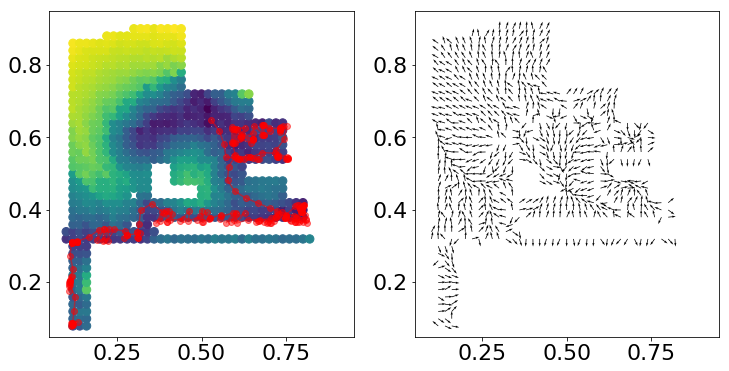

In [50]:
plotNovelty(memstart=0,memend=350)
#plt.savefig("trajectory2.pdf")

In [85]:
def plotInformativeness(target, target2):
    memstart = 0
    memend = 300
    
    testx = []
    for i in range(ptsxr.shape[0]):
        for j in range(20):
            start = np.array([ptsxr[i], ptsyr[i]]).reshape(1,2)
            theta = np.random.rand()*2*pi
            acts = np.array([[cos(theta), sin(theta)]])

            testx.append(np.hstack( [start, acts] ))

    memx = []
    memy = []

    memx.append( np.hstack( [ rmem.starts[memstart:memend], rmem.acts[memstart:memend] ]) )
    memy.append( rmem.ends[memstart:memend])

    memx = np.array(memx).transpose(0,2,1)
    memy = np.array(memy).transpose(0,2,1)

    testx = np.array(testx).transpose(1,2,0)
    target = target.reshape((1,4,1))
    target2 = target2.reshape((1,4,1))
    
    plt.rcParams.update({'font.size': 22})

    n = net.informativeness(tovar(memx), tovar(testx), tovar(target)).cpu().data.numpy()
    n = n.reshape((n.shape[1]//20,20))
    plt.subplot(2,2,1)
    plt.scatter(ptsxr, ptsyr, c=np.log(np.mean(n,axis=1)),s=70)
    plt.scatter(target[0,0,0], target[0,1,0], c='r')
    plt.plot([target[0,0,0], target[0,0,0]+target[0,2,0]*DT*50*0.15], 
             [target[0,1,0], target[0,1,0]+target[0,3,0]*DT*50*0.15], 'r-')
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)
    #plt.text(0.1,0.9,"a)")
    plt.subplot(2,2,2)

    dirs = np.argmax(n,axis=1).astype(np.int32)
    xidx = np.arange(ptsxr.shape[0])
    dx = testx[0,2,xidx*20 + dirs[xidx]]
    dy = testx[0,3,xidx*20 + dirs[xidx]]

    plt.quiver(ptsxr, ptsyr, dx, dy,scale=40)
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)
    #plt.text(0.1,0.9,"b)")

    n = net.informativeness(tovar(memx), tovar(testx), tovar(target2)).cpu().data.numpy()
    n = n.reshape((n.shape[1]//20,20))
    plt.subplot(2,2,3)
    plt.scatter(ptsxr, ptsyr, c=np.log(np.mean(n,axis=1)),s=70)
    plt.scatter(target2[0,0,0], target2[0,1,0], c='r')
    plt.plot([target2[0,0,0], target2[0,0,0]+target2[0,2,0]*DT*50*0.15], 
             [target2[0,1,0], target2[0,1,0]+target2[0,3,0]*DT*50*0.15], 'r-')
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)
    #plt.text(0.1,0.9,"a)")
    plt.subplot(2,2,4)

    dirs = np.argmax(n,axis=1).astype(np.int32)
    xidx = np.arange(ptsxr.shape[0])
    dx = testx[0,2,xidx*20 + dirs[xidx]]
    dy = testx[0,3,xidx*20 + dirs[xidx]]

    plt.quiver(ptsxr, ptsyr, dx, dy,scale=40)
    plt.xlim(0.05,0.95)
    plt.ylim(0.05,0.95)

    plt.gcf().set_size_inches((12,12))

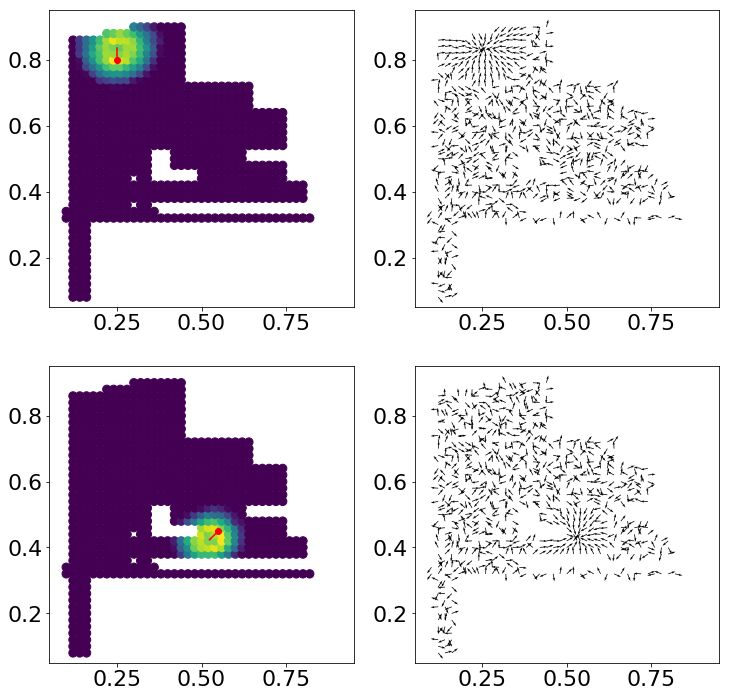

In [88]:
plotInformativeness(np.array([0.25,0.8,0,1]), np.array([0.55,0.45,-1/sqrt(2),-1/sqrt(2)]))
plt.savefig("informativeness.pdf")

## Evaluate exploration rate

In [51]:
def curiosityCurve(N, RES=32, seed=12345):
    PROPOSALS = 50
    np.random.seed(seed)
    visits = np.zeros((RES,RES))
    visit_total = []
    
    floorplan = generateFloor()
    agent = Roomba(floorplan)
    agent.randomize()
    rmem = Data()

    for i in range(20):
        theta = np.random.rand()*pi*2
        acts = np.array([cos(theta), sin(theta)]).reshape((1,2))
        start = agent.sensor()
        x = int(np.clip(start[0]*RES,0,RES-1))
        y = int(np.clip(start[1]*RES,0,RES-1))
        visits[x,y] = 1
        visit_total.append(np.sum(visits))
        
        end = np.array([agent.act(acts[0,0],acts[0,1])])
        #end = fake.sensor()

        rmem.add(start, end, acts)

    for i in range(N-20):
        memx = []
        memy = []
        idx = 0

        memx.append( np.hstack( [ rmem.starts[idx:-10], rmem.acts[idx:-10] ]) )

        testx = []
        actlist = []
        for j in range(PROPOSALS):
            theta = np.random.rand()*2*pi
            start = np.array([agent.x, agent.y]).reshape(1,2)
            acts = np.zeros((1,2))
            acts[0,0] = cos(theta)
            acts[0,1] = sin(theta)
            actlist.append(acts[0])
            testx.append(np.hstack( [start, acts] ))

        testx = np.array(testx).transpose(1,2,0)
        memx = np.array(memx).transpose(0,2,1)

        n = net.novelty(tovar(memx), tovar(testx)).cpu().data.numpy()[0]
        n = n + np.random.randn(PROPOSALS,)*0.003
        act = actlist[np.argmax(n)]

        start = agent.sensor()
        
        x = int(np.clip(start[0]*RES,0,RES-1))
        y = int(np.clip(start[1]*RES,0,RES-1))
        visits[x,y] = 1
        visit_total.append(np.sum(visits))
        
        end = np.array([agent.act(act[0],act[1])])

        acts = act.reshape((1,2))
        rmem.add(start, end, acts)
    
    return np.array(visit_total)

In [52]:
def randomWalkCurve(N, RES=32, seed=12345, strafe=1):
    np.random.seed(seed)
    visits = np.zeros((RES,RES))
    visit_total = []
    
    floorplan = generateFloor()
    agent = Roomba(floorplan)
    agent.randomize()
    rmem = Data()

    for i in range(N):
        theta = np.random.rand()*pi*2
        if i%strafe == 0:
            acts = np.array([cos(theta), sin(theta)]).reshape((1,2))
        start = agent.sensor()
        x = int(np.clip(start[0]*RES,0,RES-1))
        y = int(np.clip(start[1]*RES,0,RES-1))
        visits[x,y] = 1
        visit_total.append(np.sum(visits))
        
        end = np.array([agent.act(acts[0,0],acts[0,1])])
        #end = fake.sensor()

        rmem.add(start, end, acts)
    
    return np.array(visit_total)

## Compute exploration curves for different training times

In [54]:
COMPUTE_EXPLORATION = False

if COMPUTE_EXPLORATION:
    rcurve = np.zeros(5000)
    for i in tqdm.tqdm_notebook(range(15)):
        rcurve = rcurve + randomWalkCurve(5000,seed=10+i,RES=16)/15.0

    net.load_state_dict(torch.load("models/curious_roomba_ref_150.th"))
    ccurve = np.zeros(5000)
    for i in tqdm.tqdm_notebook(range(15)):
        ccurve = ccurve + curiosityCurve(5000,seed=10+i,RES=16)/15.0

    net.load_state_dict(torch.load("models/curious_roomba_ref_0.th"))
    ccurve_ut = np.zeros(5000)
    for i in tqdm.tqdm_notebook(range(15)):
        ccurve_ut = ccurve_ut + curiosityCurve(5000,seed=10+i,RES=16)/15.0

    net.load_state_dict(torch.load("models/curious_roomba_ref_25.th"))
    ccurve_25 = np.zeros(5000)
    for i in tqdm.tqdm_notebook(range(15)):
        ccurve_25 = ccurve_25 + curiosityCurve(5000,seed=10+i,RES=16)/15.0
else:
    # Load already-computed curves for visualization

    rcurve = np.load("rcurve.npy")
    ccurve_ut = np.load("ccurve_ut.npy")
    ccurve_150 = np.load("ccurve_150.npy")

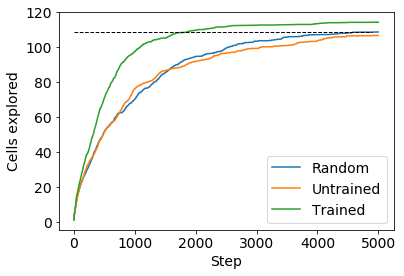

In [55]:
plt.rcParams.update({'font.size': 14})
plt.plot(rcurve, label="Random")
plt.plot(ccurve_ut, label="Untrained")
plt.plot(ccurve_150, label="Trained")
plt.plot(np.arange(50)*100,109*np.ones(50),'k--', lw=1)
plt.ylabel("Cells explored")
plt.xlabel("Step")
plt.legend()
#plt.savefig("explore2d.pdf")